In [7]:
m = 2500   # Number of words in the vocabulary
n = 200    # N most frequent words to skip
k = 0      # K least frequent words to skip

infogain = False # Not used by default
g = 800 

In [8]:
import tensorflow as tf
import numpy as np
from math import log 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
word_index = tf.keras.datasets.imdb.get_word_index()

index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vectorizer = CountVectorizer(binary=True)
x_train_binary = binary_vectorizer.fit_transform(x_train)
x_test_binary = binary_vectorizer.transform(x_test)

x_train_binary = np.array(x_train_binary.toarray())
x_test_binary = np.array(x_test_binary.toarray())

In [10]:
from math import log 

if infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0 # Αρχικοποίηση της εντροπίας του χαρακτηριστικού Hc_feature.
    for feat in feature_values:
      
      # Υπολογισμός του P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          # Υπολογισμός του P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # Υπολογισμός του - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    # Υπολογισμός του information gain.
    ig = Hc - Hc_feature
    return ig

  # Επιλογή των g πιο σημαντικών χαρακτηριστικών.
  ig = [(i, IG(y_train, x_train_binary[:, i])) for i in range(len(x_train_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]
  # Προσαρμογή των δεδομένων εκπαίδευσης και ελέγχου.
  x_train_binary = x_train_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_binary[:, [i[0] for i in ig]]

In [13]:
class BernoulliNaiveBayes:
  
  def __init__(self):
    pass 

  def fit(self, X, y):
    # Υπολογισμός της (log) a-priori πιθανότητας για κάθε κλάση
    self.p_log_pos = np.log(np.sum(y) / len(y))
    self.p_log_neg = np.log(1 - np.sum(y) / len(y))
    
    # Υπολογισμός (log) πιθανότητας για κάθε σύνολο χαρακτηριστικών δεδομένα κάθε κλάσης (y = 1 ή y = 0)
    # p(feature|class) = (np.sum(X[y == class], axis=0) + 1) / (np.sum(y) + 2)
    self.p_log_pos_feature1 = np.log((np.sum(X[y == 1], axis=0) + 1) / (np.sum(y) + 2))
    self.p_log_neg_feature1 = np.log((np.sum(X[y == 0], axis=0) + 1) / (len(y) - np.sum(y) + 2))
    self.p_log_pos_feature0 = np.log(1.0 - (np.sum(X[y == 1], axis=0) + 1) / (np.sum(y) + 2))
    self.p_log_neg_feature0 = np.log(1.0 - (np.sum(X[y == 0], axis=0) + 1) / (len(y) - np.sum(y) + 2))
    
    
  def predict(self, X):
    # Αντιστροφή των τιμών του X για να αντιστρέψουμε τον τρόπο που το μοντέλο τα περιμένει
    X_reverse = np.where((X==0)|(X==1), X^1, X)
    # Υπολογισμός των (log) πιθανοτήτων για κάθε κλάση
    p_log_pos = X_reverse.dot(self.p_log_pos_feature0) + X.dot(self.p_log_pos_feature1) + self.p_log_pos
    p_log_neg = X_reverse.dot(self.p_log_neg_feature0) + X.dot(self.p_log_neg_feature1) + self.p_log_neg
    # Καθορισμός της πρόβλεψης βάσει των (log) πιθανοτήτων
    return np.array([1 if p_log_pos[i] > p_log_neg[i] else 0 for i in range(len(X))])

In [12]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
from pandas import DataFrame
import IPython.display as ipd


def classification_data(classifier, x_train, y_train, x_test, y_test, splits = 5):

  train_accuracy, test_accuracy, train_precisions, test_precisions, train_recall, test_recall, train_f1, test_f1 = [], [], [], [], [], [], [], []
  
  # Διαίρεση των δεδομένων εκπαίδευσης σε n υποσύνολα
  split_size = int(len(x_train) / splits)
  x_splits = np.split(x_train, splits)
  y_splits = np.split(y_train, splits)
  
  # Εκπαίδευση του μοντέλου σε κάθε υποσύνολο και αξιολόγηση στο σύνολο δεδομένων ελέγχου
  for i in range(len(x_splits)):
    if i == 0:
      x_train = x_splits[0]
      y_train = y_splits[0]
    else:
      x_train = np.concatenate((curr_x, x_splits[i]), axis=0) # το υποσυνολο αυξανεται, συνενωνοντας τα προηγουμενα δεδομενα με τα επομενα
      y_train = np.concatenate((curr_y, y_splits[i]), axis=0)
    
    # Εκπαίδευση του μοντέλου και λήψη προβλέψεων εκπαίδευσης/ελέγχου
    classifier.fit(x_train, y_train)
    train_pred = classifier.predict(x_train)
    test_pred = classifier.predict(x_test)
    
    # Calculate and save the accuracy score
    train_accuracy.append(accuracy_score(y_train, train_pred))
    test_accuracy.append(accuracy_score(y_test, test_pred))
    
    # Calculate and save the precision score
    train_precisions.append(precision_score(y_train, train_pred))
    test_precisions.append(precision_score(y_test, test_pred))
    
    # Calculate and save the recall score
    train_recall.append(recall_score(y_train, train_pred))
    test_recall.append(recall_score(y_test, test_pred))
    
    # Calculate and save the f1 score
    train_f1.append(f1_score(y_train, train_pred))
    test_f1.append(f1_score(y_test, test_pred))
  
  # Calculate the final confusion matrix
  cm = confusion_matrix(y_test, test_pred) #τετραγωνικός πίνακας που δείχνει τον αριθμό των πραγματικών και προβλεπόμενων κλάσεων για ένα πρόβλημα δυαδικής ταξινόμησης.
  
  data = {'estimator': classifier.__class__.__name__, 
          'split_size': split_size, 
          'splits': splits,
          'test_predictions': test_pred,
          'train_accuracy': train_accuracy, 
          'test_accuracy': test_accuracy, 
          'train_precision': train_precisions, 
          'test_precision': test_precisions, 
          'train_recall': train_recall, 
          'test_recall': test_recall, 
          'train_f1': train_f1, 
          'test_f1': test_f1,
          'final_cm': cm}
  
  return data
  
  
def classification_table(classification_data):

  split_size = classification_data['split_size']
  df = DataFrame(data={'Train Accuracy': np.round(classification_data['train_accuracy'], 2), 
                         'Test Accuracy': np.round(classification_data['test_accuracy'], 2), 
                         'Precision Train' : np.round(classification_data['train_precision'], 2), 
                         'Precision Test' : np.round(classification_data['test_precision'], 2), 
                         'Recall Train' : np.round(classification_data['train_recall'], 2), 
                         'Recall Test' : np.round(classification_data['test_recall'], 2), 
                         'F1 Train' : np.round(classification_data['train_f1'], 2), 
                         'F1 Test' : np.round(classification_data['test_f1'], 2)}, 
                   index=list(range(split_size, len(x_train) + split_size, split_size)))
  return df


def classification_plots(classification_data, full_scale=False):

  split_size = classification_data['split_size']
  splits = classification_data['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve for {estimator}".format(estimator=classification_data['estimator']), fontsize=16)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="maroon", label="Training")
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="olive", label="Testing")
      axis[i, j].grid(alpha = 0.3)  
  
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
 
  return figure


def classification_plots_compare(classification_data_x, classification_data_y, full_scale=False):
  """
  Plots the learning curves for the train/test accuracies, precisions, recalls
  and F1 scores for each split in one figure for both classifiers.
  
  Arguments:
    classification_data_x: The dictionary containing the train/test data for the first classifier.
    classification_data_y: The dictionary containing the train/test data for the second classifier.
    full_scale: Whether or not to plot the full scale of the y-axis.
  Returns: 
    A figure containing the learning curves for the train/test accuracies, precisions, recalls and F1 scores 
    for both classifiers.
  """
  
  split_size = classification_data_x['split_size']
  splits = classification_data_x['splits']
  
  figure, axis = plt.subplots(2, 2, figsize=(6, 6), dpi=100, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]})
  figure.suptitle("Learning Curve Comparison for {estimator} against {estimator_2} ".format(estimator=classification_data_x['estimator'], estimator_2=classification_data_y['estimator']), fontsize=12)
  labels = ['Accuracy', 'Precision', 'Recall', 'F1']
  
  for i in range(0, 2):
    for j in range(0, 2):
      axis[i, j].set_title(labels[i * 2 + j])
      axis[i, j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      if full_scale:
        axis[i, j].axis(ymin=0, ymax=1.02)
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#AD49C2", label="Training {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_y['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#7CC249", label="Testing {estimator}".format(estimator=classification_data_y['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['train_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#2c8dc9", label="Training {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].plot(list(range(split_size, splits*split_size + split_size, split_size)), classification_data_x['test_' + labels[i * 2 + j].lower().replace(' ', '_')], '-', color="#FFAD00", label="Testing {estimator}".format(estimator=classification_data_x['estimator']))
      axis[i, j].grid(alpha = 0.3) 
    
  handles, labels = axis[1, 1].get_legend_handles_labels()
  figure.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fancybox=True, shadow=True)
  figure.tight_layout()
  return figure

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.83      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.87,0.83,0.88,0.85,0.86,0.81,0.87,0.83
10000,0.86,0.84,0.87,0.85,0.86,0.83,0.87,0.84
15000,0.86,0.84,0.86,0.85,0.85,0.82,0.86,0.84
20000,0.85,0.84,0.86,0.85,0.84,0.82,0.85,0.83
25000,0.85,0.84,0.85,0.85,0.85,0.83,0.85,0.84


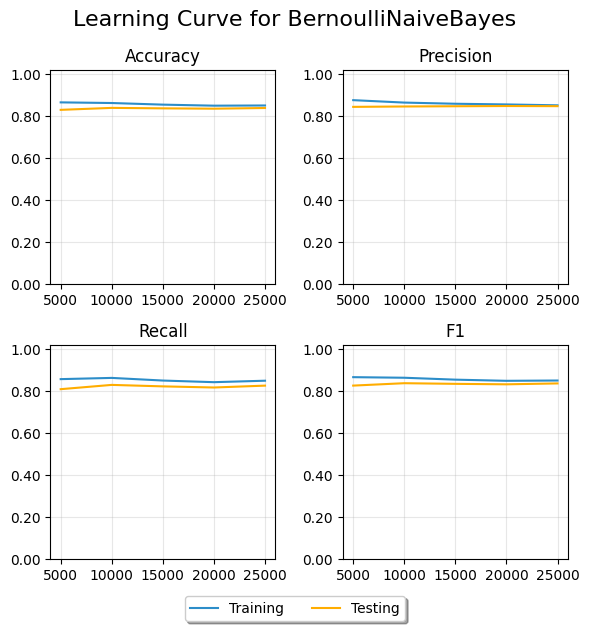

In [19]:
bnb_data = classification_data(BernoulliNaiveBayes(), x_train_binary, y_train, x_test_binary, y_test, 5)

print(classification_report(y_test, bnb_data['test_predictions']))
bnb_cf_tbl = classification_table(bnb_data)
ipd.display(bnb_cf_tbl)

bnb_cf_tplt = classification_plots(bnb_data, True)
#bnb_cf_fplt = classification_plots(bnb_data)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


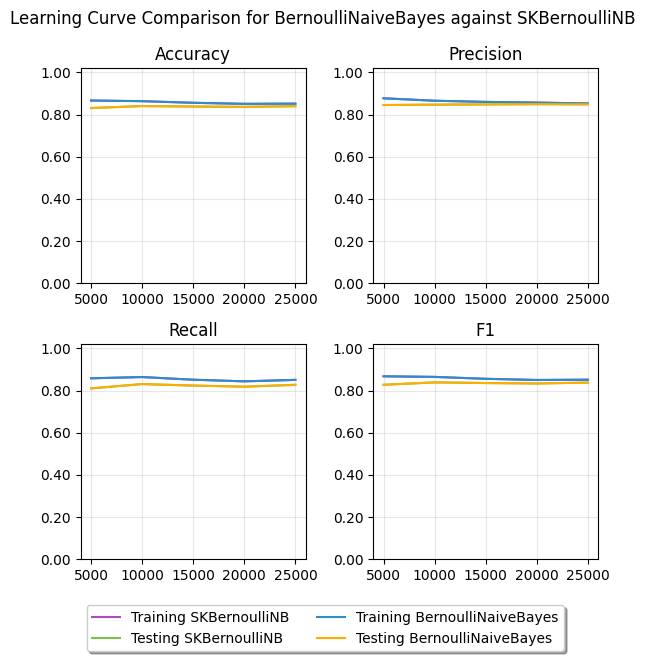

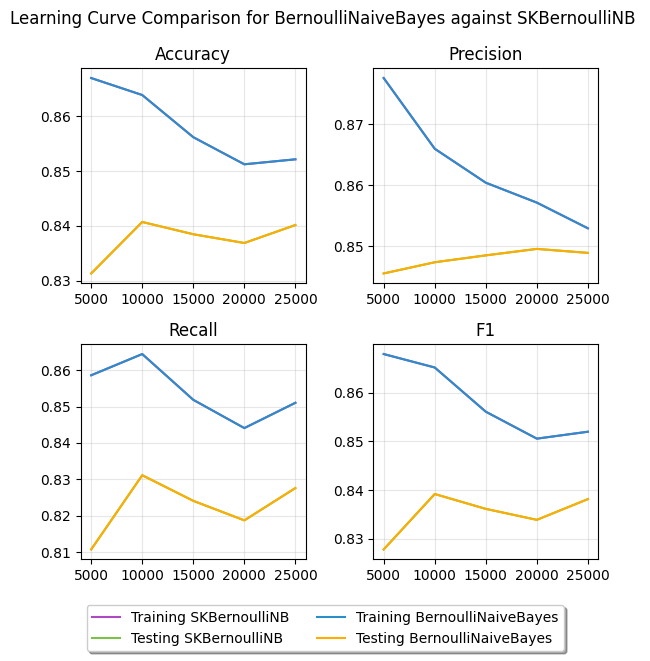

In [16]:
from sklearn.naive_bayes import BernoulliNB

skbnb_data = classification_data(BernoulliNB(), x_train_binary, y_train, x_test_binary, y_test, 5)
skbnb_data['estimator'] = 'SKBernoulliNB'
skbnb_cf_tbl = classification_table(skbnb_data)
bnb_skbnb_tbl = bnb_cf_tbl - skbnb_cf_tbl
bnb_skbnb_tbl = bnb_skbnb_tbl.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=bnb_data['estimator'], estimator_2=skbnb_data['estimator']))
ipd.display(bnb_skbnb_tbl)

bnb_skbnb_tplt = classification_plots_compare(bnb_data, skbnb_data, True)
bnb_skbnb_fplt = classification_plots_compare(bnb_data, skbnb_data)